### Test: Amount of Tokens of our scraped information and generated queries

We want to fine-tune a BERT model, yet BERT has a limitation of 512 input tokens.

After cleansing the scraped vehicle information, we need to ensure that the combination of  
vehicle information (from `vehicles_info.yaml`) combined with the individual vehicle search  
queries (from `generated_questions.json`) always stays below 512 tokens.

In [1]:
# Import libraries and setup
import json
import yaml
import re
from transformers import BertTokenizer

# Load vehicle info texts and queries
vehicle_data_path = "../../data/vehicles_info.yaml"
queries_path = "../../data/generated_questions.json"

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/storage/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the data files
# This loads the vehicle data in a different way than before and we get token limit excertions
# --> We need to find one "common way" we use everywhere to read those informationss
def get_vehicles_as_dict(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = yaml.safe_load(file)
    vehicles_dict = {}
    for url, vehicle_info in data.items():
        yaml_text = yaml.dump(vehicle_info, default_flow_style=False, allow_unicode=True)
        vehicles_dict[url] = yaml_text
    return vehicles_dict

vehicles_info = get_vehicles_as_dict(vehicle_data_path)

with open(queries_path, 'r', encoding='utf-8') as f:
    generated_questions = json.load(f)

print(f"Loaded {len(vehicles_info)} vehicle entries")
print(f"Loaded questions for {len(generated_questions)} vehicles")

Loaded 2510 vehicle entries
Loaded questions for 553 vehicles


In [3]:
def analyze_vehicle_info_token_lengths(vehicles_info, tokenizer, threshold=400):
    over_limit = 0
    token_lengths = []

    for url, info_text in vehicles_info.items():
        tokens = tokenizer.tokenize(info_text)
        token_count = len(tokens)
        token_lengths.append(token_count)
        if token_count > threshold:
            over_limit += 1

    print(f"\n[Vehicle Info Analysis]")
    print(f"Total vehicle entries: {len(vehicles_info)}")
    print(f"Entries exceeding {threshold} tokens: {over_limit}")
    print(f"Percentage: {(over_limit / len(vehicles_info)) * 100:.2f}%")
    print(f"Min: {min(token_lengths)}, Max: {max(token_lengths)}, Avg: {sum(token_lengths)/len(token_lengths):.2f}")

analyze_vehicle_info_token_lengths(vehicles_info, tokenizer, threshold=411)


[Vehicle Info Analysis]
Total vehicle entries: 2510
Entries exceeding 411 tokens: 281
Percentage: 11.20%
Min: 114, Max: 467, Avg: 287.11


In [4]:
def analyze_query_token_lengths(generated_questions, tokenizer, threshold=109):
    over_limit = 0
    total_queries = 0
    token_lengths = []

    for link, queries in generated_questions.items():
        for query in queries:
            tokens = tokenizer.tokenize(query)
            token_count = len(tokens)
            token_lengths.append(token_count)
            total_queries += 1
            if token_count > threshold:
                over_limit += 1

    print(f"\n[Query Analysis]")
    print(f"Total queries: {total_queries}")
    print(f"Queries exceeding {threshold} tokens: {over_limit}")
    print(f"Percentage: {(over_limit / total_queries) * 100:.2f}%")
    print(f"Min: {min(token_lengths)}, Max: {max(token_lengths)}, Avg: {sum(token_lengths)/len(token_lengths):.2f}")

analyze_query_token_lengths(generated_questions, tokenizer)


[Query Analysis]
Total queries: 5530
Queries exceeding 109 tokens: 0
Percentage: 0.00%
Min: 12, Max: 98, Avg: 45.09


Print tokens of an example

In [5]:
sample_link = list(vehicles_info.keys())[0]
sample = vehicles_info[sample_link]
encoded_input = tokenizer(sample, return_tensors='pt')
tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0])
#print(f"Sample formatted vehicle info: {sample}"),
print(f"Tokens: {tokens}")
print(f"Tokens in sample: {len(tokenizer.tokenize(sample))}")

Tokens: ['[CLS]', 'details', '_', 'list', ':', '-', 'ac', '-', 'leather', 'steering', 'wheel', '-', 'multi', '-', 'function', 'steering', 'wheel', '-', 'power', 'steering', '-', 'remote', 'central', 'locking', '-', 'side', 'mirror', 'electrically', 'adjustable', 'details', '_', 'text', ':', 'dem', '##ur', '##rage', 'charges', '##star', '##ting', 'on', '20', '.', '07', '.', '202', '##5', 'the', 'daily', 'dem', '##ur', '##rage', 'for', 'this', 'item', 'will', 'be', '6', ',', '00', 'eu', '##r', 'net', ',', 'plus', 'va', '##t', 'information', '_', 'di', '##ct', ':', 'category', ':', 'small', 'car', ',', '2', 'door', 'colour', ':', 'grey', 'engine', 'type', ':', 'otto', 'first', 'registration', ':', "'", '12', '.', '2020', "'", 'fuel', 'type', ':', 'petrol', 'location', ':', 'd', '-', '56', 'power', 'output', ':', '107', 'kw', '/', '146', 'ps', 'read', 'mile', '##age', ':', '23', ',', '500', 'kilometres', 'supplier', ':', 'wholesale', '##r', 'total', 'number', 'of', 'owners', ':', '2', 'own

In [6]:
# Analyze token counts for all combinations
exceeded_limit_count = 0
max_tokens = 0
longest_combination = ""
longest_link = ""
longest_query = ""
longest_info = ""
total_combinations = 0

token_counts = []
separator_token = "[SEP]"  # BERT's separator token

print("Analyzing token counts for all vehicle-query combinations...\n")

for link in generated_questions:
    if link in vehicles_info:
        # Format vehicle information
        vehicle_text = vehicles_info[link]
        
        # Process each query for this vehicle
        for query in generated_questions[link]:
            # Create combined text: vehicle_info [SEP] query
            combined_text = f"{vehicle_text} {separator_token} {query}"
            
            # Tokenize and count
            tokens = tokenizer.tokenize(combined_text)
            token_count = len(tokens)
            
            token_counts.append(token_count)
            total_combinations += 1
            
            # Check if exceeds 512 token limit
            if token_count > 512:
                exceeded_limit_count += 1
            
            # Track longest combination
            if token_count > max_tokens:
                max_tokens = token_count
                longest_combination = combined_text
                longest_link = link
                longest_query = query
                longest_info = vehicle_text
    else:
        print(f"Warning: No vehicle info found for link: {link}")

print(f"Analysis complete!")
print(f"Total combinations processed: {total_combinations}")
print(f"Combinations exceeding 512 tokens: {exceeded_limit_count}")
print(f"Percentage exceeding limit: {(exceeded_limit_count/total_combinations)*100:.2f}%")
print(f"\nToken count statistics:")
print(f"- Minimum tokens: {min(token_counts)}")
print(f"- Maximum tokens: {max(token_counts)}")
print(f"- Average tokens: {sum(token_counts)/len(token_counts):.2f}")
print(f"- Median tokens: {sorted(token_counts)[len(token_counts)//2]}")

Analyzing token counts for all vehicle-query combinations...

Analysis complete!
Total combinations processed: 5530
Combinations exceeding 512 tokens: 104
Percentage exceeding limit: 1.88%

Token count statistics:
- Minimum tokens: 141
- Maximum tokens: 540
- Average tokens: 353.15
- Median tokens: 344


In [7]:
# Display the longest combination
print("=" * 80)
print("LONGEST COMBINATION FOUND:")
print("=" * 80)
print(f"Link: {longest_link}")
print(f"Total tokens: {max_tokens}")
print(f"Info tokens: {len(tokenizer.tokenize(longest_info))}")
print(f"Query tokens: {len(tokenizer.tokenize(longest_query))}")
print(f"Exceeds limit by: {max_tokens - 512} tokens")
print("\nQuery:")
print(f'"{longest_query}"')
print("\nFull combined text:")
print(longest_combination)

# Show tokenization breakdown
print("\nTokenization breakdown:")
tokens = tokenizer.tokenize(longest_combination)
print(f"Tokens: {tokens[:20]}..." if len(tokens) > 20 else f"Tokens: {tokens}")
print(f"Total token count: {len(tokens)}")

LONGEST COMBINATION FOUND:
Link: https://autobid.de/en/item/bmw-i7-xdrive-60-design-pure-excellence-3105732/details
Total tokens: 540
Info tokens: 454
Query tokens: 85
Exceeds limit by: 28 tokens

Query:
"Looking for a BMW saloon, 4 door, with all-wheel drive and powered by an electric engine. The car should be grey metallic in color and have an automatic transmission system. The vehicle should have a power output of more than 100 KW and less than 200 KW. It should have onboard features like LED headlights, automatic tailgate, and satnav with map views. Has it driven less than 20,000 kilometres?"

Full combined text:
details_list:
- 'Airbags: 8'
- Alarm system
- Auto Hold
- Autobeam
- Automatic dimming exterior mirror
- Automatic dimming internal mirror
- Automatic tailgate
- Climatronic
- Cruise control
- Electric windows front and rear
- Fixed panorama roof
- Head-up display
- Lane Change Warning
- Lane keeping system
- Leather steering wheel
- LED headlights
- Multi-function steerin

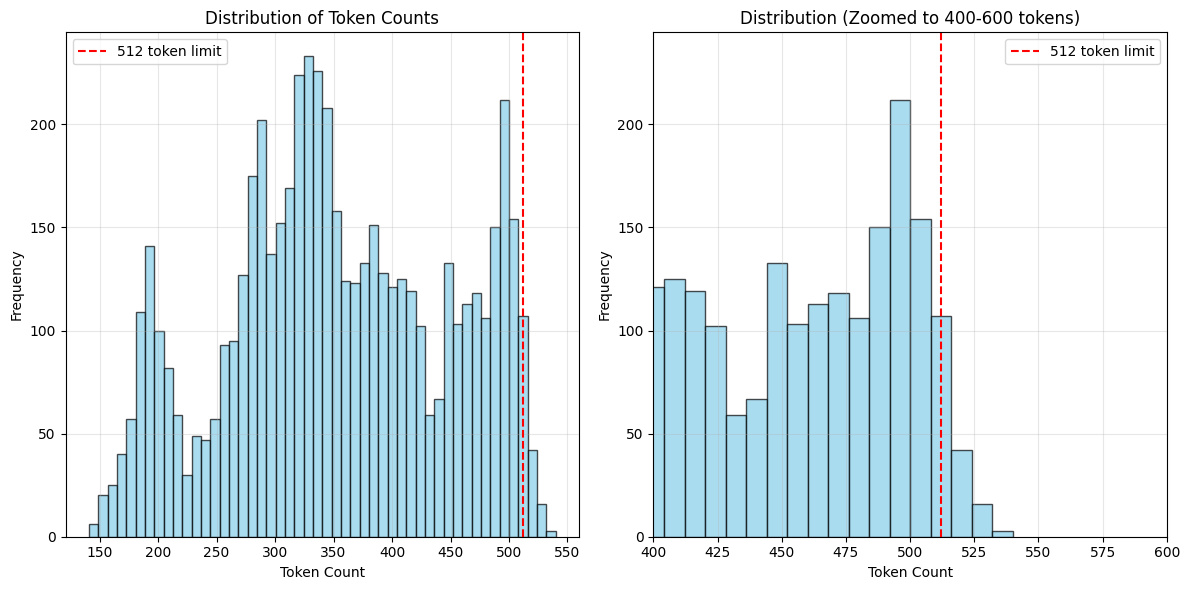


Token count distribution by ranges:
  0-256 tokens: 854 combinations (15.4%)
  256-384 tokens: 2604 combinations (47.1%)
  384-512 tokens: 1953 combinations (35.3%)
  512-600 tokens: 119 combinations (2.2%)
  600+ tokens: 0 combinations (0.0%)


In [8]:
# Token count distribution analysis
import matplotlib.pyplot as plt
import numpy as np

# Create histogram of token counts
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(token_counts, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=512, color='red', linestyle='--', label='512 token limit')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Distribution of Token Counts')
plt.legend()
plt.grid(True, alpha=0.3)

# Show only the area around the limit
plt.subplot(1, 2, 2)
plt.hist(token_counts, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=512, color='red', linestyle='--', label='512 token limit')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Distribution (Zoomed to 400-600 tokens)')
plt.xlim(400, 600)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Count tokens in different ranges
ranges = [(0, 256), (256, 384), (384, 512), (512, 600), (600, float('inf'))]
print("\nToken count distribution by ranges:")
for start, end in ranges:
    count = sum(1 for tc in token_counts if start <= tc < end)
    percentage = (count / total_combinations) * 100
    range_str = f"{start}-{end}" if end != float('inf') else f"{start}+"
    print(f"  {range_str} tokens: {count} combinations ({percentage:.1f}%)")